<a href="https://colab.research.google.com/github/pseudope/Parrot_5th_Level1_2/blob/main/11_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install jupyternotify
#%load_ext jupyternotify

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
import os
import numpy as np
import pandas as pd
from pprint import pprint

import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
path = '/content/gdrive/My Drive/train/'

dataset = os.listdir(path)

dataset.sort()

len(dataset)
pprint(dataset)

['bart',
 'charles_montgomery',
 'krusty',
 'lisa_simpson',
 'marge_simpson',
 'milhouse_van_houten',
 'moe_szyslak',
 'ned_flanders',
 'principal_skinner']


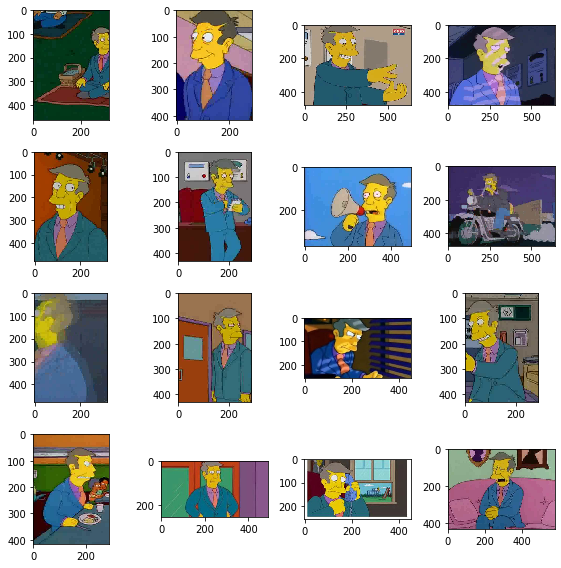

In [ ]:
fig = plt.figure(figsize=(8, 8))

for i in range(16):

    plt.subplot(4, 4, 1 + i)
    plt.tight_layout()

    image_bgr = cv2.imread(path + "{}".format(dataset[i]))
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    plt.imshow(image_rgb, cmap="rainbow", interpolation="none")
    #target = np.where(example_target[i]==1)[0]
    #plt.title("Ground Truth: {}".format(category.get(int(target))))

plt.show()

In [ ]:
for i in range(5):
  image_bgr = cv2.imread(path + "{}".format(dataset[i]))
  image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
  print(image_rgb.shape)

(464, 320, 3)
(416, 288, 3)
(480, 640, 3)
(480, 640, 3)
(480, 320, 3)


## Dataframe으로 정리

In [ ]:
top_path = '/content/gdrive/My Drive/train/'
path_list = []
category_list = []
categories = ["bart", "charles_montgomery", "krusty", "lisa_simpson", "marge_simpson", "milhouse_van_houten", "moe_szyslak", "ned_flanders", "principal_skinner"]

for category in categories:
  path = top_path+category+"/"
  dataset = os.listdir(path)
  
  for data in dataset:
    path_list.append(path + "{}".format(data))
    category_list.append(category)


df = pd.DataFrame({"path": path_list, "category": category_list})

print(df.shape)
print(df["category"].unique())
df.value_counts("category")

(11258, 2)
['bart' 'charles_montgomery' 'krusty' 'lisa_simpson' 'marge_simpson'
 'milhouse_van_houten' 'moe_szyslak' 'ned_flanders' 'principal_skinner']


category
ned_flanders           1454
moe_szyslak            1452
lisa_simpson           1354
marge_simpson          1311
bart                   1218
principal_skinner      1203
krusty                 1101
charles_montgomery     1086
milhouse_van_houten    1079
dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11258 entries, 0 to 11257
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   path      11258 non-null  object
 1   category  11258 non-null  object
dtypes: object(2)
memory usage: 176.0+ KB


In [ ]:
df

,path,category
0,/content/gdrive/My Drive/train/bart/pic_1157.jpg,bart
1,/content/gdrive/My Drive/train/bart/pic_1270.jpg,bart
2,/content/gdrive/My Drive/train/bart/pic_1178.jpg,bart
3,/content/gdrive/My Drive/train/bart/pic_0795.jpg,bart
4,/content/gdrive/My Drive/train/bart/pic_1107.jpg,bart
...,...,...
11253,/content/gdrive/My Drive/train/principal_skinn...,principal_skinner
11254,/content/gdrive/My Drive/train/principal_skinn...,principal_skinner
11255,/content/gdrive/My Drive/train/principal_skinn...,principal_skinner
11256,/content/gdrive/My Drive/train/principal_skinn...,principal_skinner


# Data Loader + Preprocessing

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

In [ ]:
#!/usr/bin/env python3
#!pip install einops
#!pip install tensorflow --user

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os

from tensorflow.data import Dataset
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout, Flatten, Activation, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50V2, DenseNet201, EfficientNetB0, ResNet101V2, DenseNet169, DenseNet121
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

#from einops import rearrange
from sklearn.model_selection import train_test_split

In [ ]:
from tensorflow.keras.utils import to_categorical, Sequence

class DataGenerator(Sequence):
    def __init__(self, list_IDs, labels, 
    batch_size, img_size, img_channel, num_classes, augmentations, shuffle=False):
     
        # 데이터 이미지 개별 주소 [ DataFrame 형식 (image 주소, image 클래스) ]
        self.list_IDs = list_IDs
        # 데이터 라벨 리스트 [ DataFrame 형식 (image 주소, image 클래스) ]
        self.labels = labels
        # 학습 Batch 사이즈
        self.batch_size = batch_size
        # 이미지 리사이징 사이즈
        self.img_size = img_size
        # 이미지 채널 [RGB or Gray]
        self.img_channel = img_channel
        # 데이터 라벨의 클래스 수
        self.num_classes = num_classes
        # 전체 데이터 수
        self.indexes = np.arange(len(self.list_IDs))
        self.shuffle=shuffle
        self.on_epoch_end()
        self.augment = augmentations
   
    def __len__(self):
        len_ = int(len(self.list_IDs)/self.batch_size)
        if len_*self.batch_size < len(self.list_IDs):
            len_ += 1
        return len_
    
    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        X, y = self.__data_generation__(list_IDs_temp, index)
        
        return np.stack([
            self.augment(image=x)["image"] for x in X
        ], axis=0), y#to_categorical(y, num_classes=self.num_classes)
        #return X, y
            
    def __data_generation__(self, list_IDs_temp, index):
        X = np.zeros((self.batch_size, self.img_size, self.img_size, self.img_channel), dtype='uint8')
        y = np.zeros((self.batch_size, self.num_classes), dtype=int)
        for i, ID in enumerate(list_IDs_temp):
            img = cv2.imread(ID)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (self.img_size, self.img_size))
            X[i, ] = img 
            y[i, ] = to_categorical(self.labels[index*self.batch_size+i], num_classes=self.num_classes)
        return X, y
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

In [ ]:
import albumentations as A

AUGMENTATIONS_TRAIN = A.Compose([
    A.CLAHE(p=1.0, clip_limit=2.0),
    #A.ToFloat(max_value=255),
    A.Normalize(mean=(0, 0, 0), std=(1, 1, 1)),
    A.HorizontalFlip(p=0.5),
    #A.RandomContrast(limit=0.2, p=0.5),
    
    #A.RandomBrightness(limit=0.2, p=0.5),
    A.OneOf([
        A.RandomBrightnessContrast(brightness_limit=0.2, 
                                   contrast_limit=0.2, p=0.5),
        A.RandomGamma(gamma_limit=(80, 120), p=0.5)
    ]),
    #A.GaussianBlur(p=0.2),
    A.ShiftScaleRotate(
        shift_limit=0.01, scale_limit=0.1, 
        rotate_limit=30, border_mode=cv2.BORDER_REFLECT_101, p=0.3)
])
AUGMENTATIONS_TEST = A.Compose([
    A.CLAHE(p=1.0, clip_limit=2.0),
    #A.ToFloat(max_value=255),
    A.Normalize(mean=(0, 0, 0), std=(1, 1, 1))
])

In [ ]:
# 전체 클래스 수
clss_num = len(df['category'].unique())
# 클래스 -> 숫자로 변환 (카테고리 형식의 클래스를 원 핫 인코딩)
labels_dict = dict(zip(df['category'].unique(), range(clss_num)))
df = df.replace({"category": labels_dict})

data = df['path']
target = df['category']


x_train, x_valid, y_train, y_valid = train_test_split(data, target, test_size=0.2, shuffle=True, stratify=target)
x_train.reset_index(drop=True, inplace=True), x_valid.reset_index(drop=True, inplace=True), y_train.reset_index(drop=True, inplace=True), y_valid.reset_index(drop=True, inplace=True)


(None, None, None, None)

In [ ]:
x_train, y_train

(0        /content/gdrive/My Drive/train/bart/pic_0815.jpg
 1       /content/gdrive/My Drive/train/milhouse_van_ho...
 2       /content/gdrive/My Drive/train/charles_montgom...
 3       /content/gdrive/My Drive/train/principal_skinn...
 4       /content/gdrive/My Drive/train/principal_skinn...
                               ...                        
 9001    /content/gdrive/My Drive/train/charles_montgom...
 9002    /content/gdrive/My Drive/train/moe_szyslak/pic...
 9003    /content/gdrive/My Drive/train/milhouse_van_ho...
 9004    /content/gdrive/My Drive/train/moe_szyslak/pic...
 9005    /content/gdrive/My Drive/train/marge_simpson/p...
 Name: path, Length: 9006, dtype: object, 0       0
 1       5
 2       1
 3       8
 4       8
        ..
 9001    1
 9002    6
 9003    5
 9004    6
 9005    4
 Name: category, Length: 9006, dtype: int64)

In [ ]:
target_size = 224
img_ch = 3
num_class = 9
batch_size = 32

train_generator = DataGenerator(x_train,
                                y_train,
                                batch_size, target_size, 
                                img_ch, num_class, AUGMENTATIONS_TRAIN)
valid_generator = DataGenerator(x_valid, 
                                y_valid,
                                batch_size, target_size,
                                img_ch, num_class, AUGMENTATIONS_TEST)

In [ ]:
x_train.shape

(9006,)

In [ ]:
#examples = list(enumerate(train_generator))
#len(examples)

Target: (32, 9)
Data  : (32, 224, 224, 3)
[0 0 0 0 0 0 0 0 1]
[0 0 0 0 0 0 0 0 1]
[0 0 0 0 0 0 0 0 1]
[0 0 0 0 0 0 0 0 1]
[0 0 0 0 0 0 1 0 0]
[0 0 0 0 0 0 0 0 1]
[0 0 0 0 0 0 0 0 1]
[0 0 0 1 0 0 0 0 0]
[0 0 0 0 0 0 0 1 0]


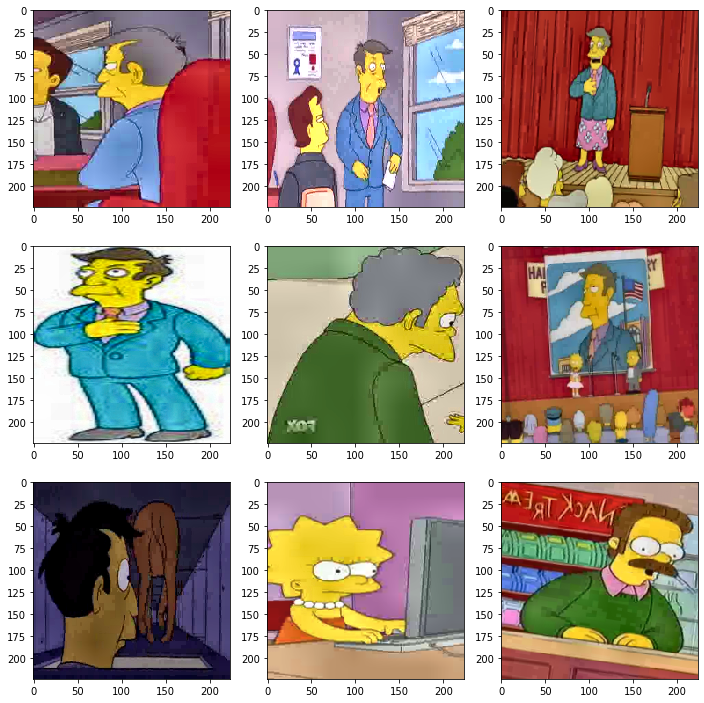

In [ ]:
examples = enumerate(train_generator)
next(examples)
next(examples)
next(examples)
batch_idx, (example_data, example_target) = next(examples)

print("Target: {}".format(example_target.shape))
print("Data  : {}".format(example_data.shape))
fig = plt.figure(figsize=(10, 10))

for i in range(9):
    plt.subplot(3, 3, 1 + i)
    plt.tight_layout()
    plt.imshow(tf.squeeze(example_data[i]), cmap="rainbow", interpolation="none")
    target = np.where(example_target[i]==1)[0]
    #plt.title("Ground Truth: {}".format(category.get(int(target))))
    print(example_target[i])
plt.show()

## 모델 구현

### 전이 학습 모델 (DenseNet121)

In [ ]:
# number of classes
K = 9
base_model = DenseNet121(#input_tensor=inputs,
                         weights="imagenet", 
                         input_shape=(224, 224, 3), 
                         include_top=False)

inputs = Input(shape=(224,224,3))
base_model.trainable = False

X = base_model(inputs, training = False)
X = GlobalAveragePooling2D()(X)
X = Flatten()(X) 
X = Dense(1024, activation="relu")(X)
X = BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform")(X)
X = Dropout(0.6)(X)
X = Dense(256, activation='relu')(X)
X = BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform")(X)
X = Dropout(0.3)(X) 

outputs = Dense(K, activation='softmax')(X)
 
model = Model(inputs, outputs)

model.summary()


29097984/29084464 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 1024)              1049600   
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096   

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, verbose=1, mode='min')
mc = ModelCheckpoint("best{:02d}.ckpt".format(i+1), monitor='val_loss', verbose=1, save_best_only=True, save_weight_only=True, mode='min', restore_best_weights=True)
rl = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1,  min_delta=0.001, min_lr=0.00001)

model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=["accuracy"])
history = model.fit(train_generator, epochs=30, callbacks = [es,mc,rl],  validation_data=valid_generator, verbose=1)
#model.load_weights(checkpoint_filepath)

Epoch 1/30
282/282 [==============================] - ETA: 0s - loss: 1.1912 - accuracy: 0.6586
Epoch 00001: val_loss improved from inf to 0.57502, saving model to best09.ckpt
INFO:tensorflow:Assets written to: best09.ckpt/assets
282/282 [==============================] - 2740s 10s/step - loss: 1.1912 - accuracy: 0.6586 - val_loss: 0.5750 - val_accuracy: 0.8068 - lr: 0.0010
Epoch 2/30
282/282 [==============================] - ETA: 0s - loss: 0.6766 - accuracy: 0.7787
Epoch 00002: val_loss improved from 0.57502 to 0.50123, saving model to best09.ckpt
INFO:tensorflow:Assets written to: best09.ckpt/assets
282/282 [==============================] - 2021s 7s/step - loss: 0.6766 - accuracy: 0.7787 - val_loss: 0.5012 - val_accuracy: 0.8336 - lr: 0.0010
Epoch 3/30
282/282 [==============================] - ETA: 0s - loss: 0.5963 - accuracy: 0.8034
Epoch 00003: val_loss improved from 0.50123 to 0.47767, saving model to best09.ckpt
INFO:tensorflow:Assets written to: best09.ckpt/assets
282/282 [

### Result Visualization

In [ ]:
def acc_loss_plot(hist):
    
    fit, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()
    
    loss_ax.plot(hist.history["loss"], "y", label="train_loss")
    loss_ax.plot(hist.history["val_loss"], "r", label="val_loss")
    loss_ax.set_xlabel("Epoch")
    loss_ax.set_ylabel("Loss")
    loss_ax.legend(loc = "upper left")
    
    acc_ax.plot(hist.history["accuracy"], "b", label="train_acc")
    acc_ax.plot(hist.history["val_accuracy"], "g", label="val_acc")
    acc_ax.set_ylabel("Accuracy")
    acc_ax.legend(loc = "upper right")
    
    plt.show()

In [ ]:
acc_loss_plot(history)

NameError: ignored

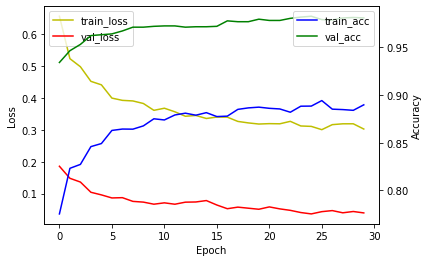

In [ ]:
acc_loss_plot(history2)

### Test Set Prediction

In [ ]:
top_path = '/content/gdrive/My Drive/train/'
path_list = []

dataset = os.listdir(top_path)
  
for data in dataset:
  path_list.append(top_path + "{}".format(data))

X_test = pd.Series(path_list)
print(X_test.shape)

(1086,)


In [ ]:
class TestDataGenerator(Sequence):
    def __init__(self, list_IDs, batch_size, img_size, img_channel, augmentations):
     
        # 데이터 이미지 개별 주소 [ DataFrame 형식 (image 주소, image 클래스) ]
        self.list_IDs = list_IDs

        # 학습 Batch 사이즈
        self.batch_size = batch_size
        # 이미지 리사이징 사이즈
        self.img_size = img_size
        # 이미지 채널 [RGB or Gray]
        self.img_channel = img_channel

        # 전체 데이터 수
        self.indexes = np.arange(len(self.list_IDs))

        self.augment = augmentations
   
    def __len__(self):
        len_ = int(len(self.list_IDs)/self.batch_size)
        if len_*self.batch_size < len(self.list_IDs):
            len_ += 1
        return len_
    
    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        X = self.__data_generation__(list_IDs_temp)#, index)
        
        return np.stack([
            self.augment(image=x)["image"] for x in X
        ], axis=0)
            
    def __data_generation__(self, list_IDs_temp):#, index):
        X = np.zeros((self.batch_size, self.img_size, self.img_size, self.img_channel), dtype='uint8')
        
        for i, ID in enumerate(list_IDs_temp):
            img = cv2.imread(ID)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (self.img_size, self.img_size))
            X[i, ] = img 
        return X
    

test_generator = TestDataGenerator(X_test, batch_size, target_size,
                                img_ch, AUGMENTATIONS_TEST )

In [ ]:
model.load_weights(checkpoint_filepath)
predictions = model.predict(test_generator)

categ_map = dict(zip(range(9), categories))


predictions = np.argmax(predictions, axis = 1)
predictions = np.vectorize(categ_map.get)(predictions)

output = pd.DataFrame({'files': dataset, 'pred': predictions[:len(X_test)]})
output.to_csv('test_pred_DenseNet121.csv')

In [ ]:
output.head()

,files,pred
0,test10013.jpg,krusty
1,test10019.jpg,ned_flanders
2,test10028.jpg,ned_flanders
3,test10074.jpg,charles_montgomery
4,test10084.jpg,lisa_simpson
